# Lab 7 - Variational Autoencoders

In this lab, you will implement and play with a Variational Autoencoder. To be able to compare our results with last week's lab, we will use the MNIST digits dataset and use PyTorch for the implementation.

**Guidelines for the graded lab:**
* The lab should be sent to marine.le-morvan@inria.fr before next Tuesday midnight.
* Labs should be sent in html format (with all cells exectued).
* Name your lab as lab6_yourname.html
* Quality of the code and figures will be taken into account.
* If you think something is weird in your results but you can't figure out why, you can add a comment on this.
* This is a personal assignment. Therefore, there should not be inadequate similarities between your lab and someone else's lab.

## Table of contents


[1 VAE implementation](#VAE_implementing)<br>
[2 Image generation and latent space visualization](#VAE_generating)<br>

# 1 VAE Implementation
<a id='VAE_implementing'></a>

In this section, we will implement variational autoencoders for the flattened images in the MNIST dataset. 

The loss minimized by a VAE is called the **Evidence Lower Bound (ELBO)**. It is given by:

$$\mathcal L(\theta, \phi) = \mathbb E{q_\phi}\left[\ln p_\theta(x|z)\right] - KL\left(q_\phi(z|x) || p_\theta(z)\right)$$
where:
* the likelihood and the prior distributions are parametrized by $\theta$ and denoted as $p_\theta(x|z)$ and $p_\theta(z)$.
* the posterior distribution is approximated by the proposal distribution $q_\phi(z|x)$, which is parametrized by $\phi$.

In order to implement a VAE, one has to make choices for the parametrizations of these distributions. In this lab, we will choose:
* $p_\theta(z) = \mathcal N(z|0, I)$.
* $p_\theta(x|z) = \mathcal N(x|\mu_\theta(z), \Sigma_\theta(z))$ with $\Sigma_\theta(z)$ equal to Identity.
* $q_\phi(z|x) = \mathcal N(z|\mu_\phi(x), \Sigma_\phi(x))$ with $\Sigma_\phi(x)$ diagonal.

These choice are classical except may be for the choice of setting $\Sigma_\theta(z)$ equal to Identity. However, it will simplify the exercice.

We will start by implementing the encoder and decoder networks.

In [ ]:
import torch
import torch.nn as nn
import numpy as np

###  Encoder

**1) Create an `Encoder` network.**

You should create a class `Encoder` that:
* takes a flatten MNIST image as input
* contains one hidden layer of size `d_hidden = 256` (with ReLU).
* outputs two vectors `z_mean` and `z_log_var`, each one of size `d_z=2`, corresponding to the means and log-variances of each component of the latent variable `z`.

In [ ]:
class Encoder(torch.nn.Module):
    def __init__(self, d_hidden = 256):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Linear(784, d_hidden),
            nn.ReLU(),
            nn.Linear(d_hidden, 4)
        )

    def forward(self, X):
        output = self.stack(X)
        return output

### Decoder

**2) Create a `Decoder` network.**

You should create a class `Decoder` that:
* takes a latent variable `z` as input.
* contains one hidden layer of size `d_hidden = 256` (with ReLU).

Explain what the output of this layer should be and implement the correct output.

Apply a sigmoid non-linearity to your output before returning it. Adding a sigmoid non-linearity may or may not be necessary depending on how the loss is implemented. In this lab, the loss is implemented for you and it requires that a sigmoid non-linearity is applied to your output.

In [ ]:
class Decoder(torch.nn.Module):
    def __init__(self, d_hidden = 256):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Linear(2, d_hidden),
            nn.ReLU(),
            nn.Linear(d_hidden, 784), # means
            nn.Sigmoid()
        )

    def forward(self, X):
        output = self.stack(X)
        return output

In [ ]:
## The output of this network, according to the graph drawn during the practical work,
## should be values of mean and variance. For mean values, as we have 784 pixels, 784 mean values 
## should be outputed. As for variance, it is going to be identity matrix, so there is no need
## to output it. 
## As a result, the output will be the 784 mean values.

### The sampling layer

In order for the gradient to be able to flow backwards in a VAE model, we need to use the reparametrization trick. The random variable z is conditioned on the input image x as follows:

$$ z \sim \mathcal{N}(z|\mu_\phi(x), \sigma_\phi(x)) $$

where $\sigma_\phi(x) = diag(\Sigma_\phi(x))$. The reparametrization tricks rewrites $z$ has follows:

$$ z = \mu_\phi(x) + \sigma_\phi(x) \cdot \epsilon$$

with:

$$ \epsilon \sim \mathcal{N}(0, 1) $$

This way the dependency between $z$ and $x$ is deterministic and differentiable. The randomness of $z$ only stems from $\epsilon$.

Note that in practice the output of the encoder network parameterizes $log(\sigma^2_\phi(x))$ instead of $\sigma_\phi(x)$. Taking the exponential of $log(\sigma^2_\phi(x))$ ensures the positivity of the standard deviation from the raw output of the network.

**3) Using the reparametrization trick for Gaussian variables, create a `Sampling` layer.**

The sampling layer:
* takes as input $log(\sigma^2_\phi(x))$ as well as $\mu_\phi$.
* outputs a latent variable $z$ with the correct distribution.

**Hint 1**: you can use the `torch.distributions.Normal` object to do sampling.  
**Hint 2**: the first dimension of your tensors are the batch size!

In [ ]:
def sampling(z_mean,z_log_var, batch_size):
    es = torch.distributions.Normal(torch.zeros((batch_size,2)), torch.ones((batch_size,2))) 
    es_sample = es.sample()
    z = z_mean + torch.sqrt(torch.exp(z_log_var)) * es_sample
    return z

### The VAE

**4) Combine the previous questions to create a VAE network called `VAE`.**

In [ ]:
class VAE(torch.nn.Module):
    def __init__(self, d_hidden):
        super().__init__()
        self.d_hidden = d_hidden 
        self.batch_size = None
        self.z_mean = None
        self.z_log_var = None
        self.stack = nn.Sequential(
            nn.Linear(784, self.d_hidden),
            nn.ReLU(),
            nn.Linear(self.d_hidden, 4)
        )
        self.stack2 = nn.Sequential(
            nn.Linear(2, self.d_hidden),
            nn.ReLU(),
            nn.Linear(self.d_hidden, 784),
            nn.Sigmoid()
        )

    def decoder(self, X):
        return self.stack2(X)

    def encoder(self,X):
        self.batch_size = X.size()[0]
        return self.stack(X)

    def sampling(self):
        es = torch.distributions.Normal(torch.zeros((self.batch_size,2)), torch.ones((self.batch_size,2))) 
        es_sample = es.sample()
        z = self.z_mean + torch.sqrt(torch.exp(self.z_log_var)) * es_sample
        return z

    def forward(self, X):
        encoded = self.encoder(X)
        self.z_log_var, self.z_mean = self.encoder(X)[:,:2], self.encoder(X)[:,2:4]
        z = self.sampling()
        outputs = self.decoder(z)
        return outputs

**5) Check that the forward pass works (i.e no error raised) by feeding it a batch of samples.**

For this, we load the MNIST dataset using the `torchvision`package, and scale the data in [0, 1]. We then recover a batch of flattened MNIST images. You can use this batch to feed the VAE and check that no error arises.

In [ ]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transforms.ToTensor())
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transforms.ToTensor())

print(f'Shape of the training set: {trainset.train_data.shape}')
print(f'Shape of the the test set: {testset.test_data.shape}')

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
X_train_batch, _ = iter(trainloader).next()
X_train_batch = X_train_batch.view(64, -1)
print(f'Shape of the training batch: {X_train_batch.shape}')

Shape of the training set: torch.Size([60000, 28, 28])
Shape of the the test set: torch.Size([10000, 28, 28])
Shape of the training batch: torch.Size([64, 784])


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [ ]:
# checking the model with one batch of train data
model = VAE(d_hidden=256)
outputs = model(X_train_batch)

In [ ]:
print(outputs.shape)

torch.Size([64, 784])


### The VAE loss

Now that we have a VAE architecture ready, we need to compute the ELBO.

With our choices of distributions, the KL part of the ELBO can be computed analytically (see the expression given on the lecture slides).

To compute the part of the ELBO that contains the expectation, we will approximate the expectation by the mean over the current batch of samples.

Making use of these information, we now implement the ELBO:

In [ ]:
from torch.nn import functional as F

def ELBO(z_log_var, z_mean, x_new, x):
    batch_size = x.shape[0]
    kl_loss = 1 + z_log_var - z_mean.pow(2) - torch.exp(z_log_var)
    kl_loss = -0.5*torch.sum(kl_loss, axis=-1).mean()
    
    bce = F.binary_cross_entropy(x_new, x, reduction='sum')/batch_size
    
    return kl_loss + bce

### Training the VAE

**6) Train the network on the flattened MNIST images.**

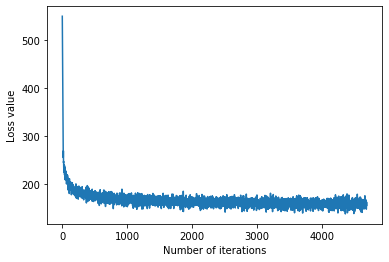

In [ ]:
model = VAE(d_hidden=256)
epochs = 5
losses = []
optimizer = torch.optim.Adam(model.parameters())
for epoch in range(0,epochs):
    for (images, labels) in trainloader:
        images = images.reshape(-1,784)
        if(len(images) == 64):
            output_images = model(images)
            loss = ELBO(model.z_log_var, model.z_mean, output_images,images)
            losses.append(loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
plt.xlabel('Number of iterations')
plt.ylabel('Loss value')
plt.plot(losses)


In [ ]:
print("The value of loss for last iteration: ",losses[-1]) 

The value of loss for last iteration:  tensor(156.1647, grad_fn=<AddBackward0>)


**7) In order to check that your training went well, plot side by side one sample and its reconstruction by the VAE (both reshaped as images).**

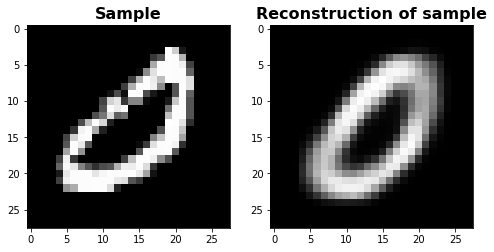

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(8,10))
axs[0].set_title("Sample", fontsize=16,fontweight='bold')
axs[1].set_title("Reconstruction of sample", fontsize=16,fontweight='bold')
axs[0].imshow(X_train_batch[0].reshape(28,28), cmap ="gray")
outp_image = model(X_train_batch)
axs[1].imshow(outp_image[0].detach().numpy().reshape(28,28), cmap ="gray")


# 2  Image generation and latent space visualization
<a id='VAE_generating'></a>

**8) Use the trained network to generate 10 random images and plot them (in a 2x5 array). Any comments on the resulting images?**

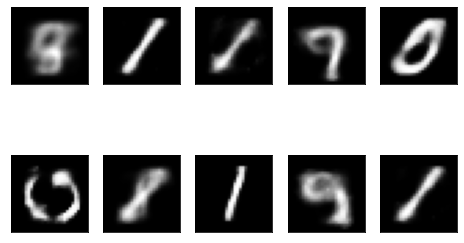

In [ ]:
import random
fig, axs = plt.subplots(2,5, figsize=(8,5))

for i in range(2):
    for j in range(5):
        outp_image = model.decoder(torch.tensor([ random.uniform(-4, 4), random.uniform(-4, 4)]))
        axs[i,j].imshow(outp_image.detach().numpy().reshape(28,28), cmap = 'gray')
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])


In [ ]:
## We can see from the image above that the resulting random images represent 
## different digits (Here 1,8,9,0). The digits that will be represented depend
## on the range for selecting the random variables that we provide to decoder.

**9) Use the encoder to visualize the distribution of the first 1000 samples of the train set in the 2D latent space of the VAE model.**

In [ ]:
trainloader_new = DataLoader(trainset, batch_size=1000, shuffle=True)
X_train_batch_new, labels = iter(trainloader_new).next()
X_train_batch_new = X_train_batch_new.view(1000, -1)

In [ ]:
encoded_values = model.encoder(X_train_batch_new)
log_var, mean = encoded_values[:,:2], encoded_values[:,2:4]
latent = sampling(mean,log_var, 1000)

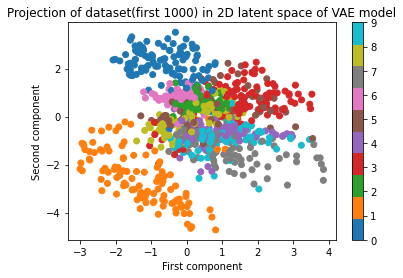

In [ ]:
plt.title('Projection of dataset(first 1000) in 2D latent space of VAE model')
plt.xlabel('First component')
plt.ylabel('Second component')

plt.scatter(latent[:,0].detach().numpy(), latent[:,1].detach().numpy(), c = labels, cmap ='tab10')
plt.colorbar()
plt.show()

**10) Produce a picture similar the one given below.**

The figure should be similar in spirit, you may not obtain the exact same numbers as on this picture.

To help you generate such a figure, we provide below part of the code and you should complete it.

**Hint**: two generated images are going to be close if the latent variables from which they are generated are close.

<img src="square_image_MNIST.png" width="600px" />

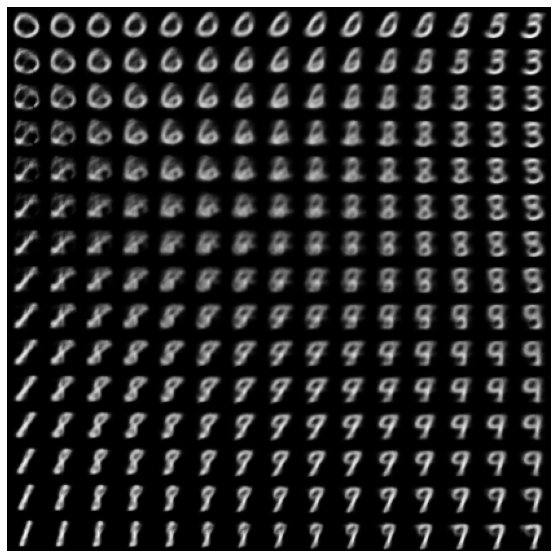

In [ ]:
from scipy.stats import norm

n = 15  
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n)).astype(np.float32)
grid_y = norm.ppf(np.linspace(0.05, 0.95, n)).astype(np.float32)

for i, y in enumerate(grid_x):
        for j, x in enumerate(grid_y):
            z = torch.Tensor([[x, y]])
            image = model.decoder(z)
            image = image.reshape(28, 28).detach().numpy()
            figure[(n-1-i)*digit_size : (n-1-i+1)*digit_size, j*digit_size : (j+1)*digit_size] = image

plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(figure, cmap='gray')
plt.show()

In this lab, we implemented a VAE whose encoder and decoder are feedforward neural networks for simplicity. However, since our dataset is made of images, it would have been a good idea to use convolutional layers in both the encoder and decoder networks. With images, using convolutional layers allows the VAE to learn more meaningful latent representations. It is actually a good exercice to follow the same steps as in this lab to implement a convolutional VAE. It is a good training for implementing CNN layers in PyTorch, and it allows you to explore the latent space learned with convolutions.

In [ ]:
%%shell
jupyter nbconvert --to html /content/lab7_IradaBunyatova.ipynb


[NbConvertApp] Converting notebook /content/lab7_IradaBunyatova.ipynb to html
[NbConvertApp] Writing 732250 bytes to /content/lab7_IradaBunyatova.html
